# Harvest and Thrive
The following notebook presents my final project for the Reinforcement Learning class "Harvest and Thrive".

I will summarize here how i modelled the problem, starting from the environment and then i'll go through the agent implementation with several exploration variants.

For each variant i'll present plots of the reward gained and i'll distinguish the reward on which the agent has learned on from the actual objective (having a large end-of-year harvest)

---
### Hardware
For this project i had acess to an RTX3060 (laptop version), and (although sporadically) two T4 GPUs. 

---
### LLM use disclaimer
LLMs have been used, mostly to speed up research and understanding of methods that were not covered in class (see ICM) and slightly for coding (Github copilot autocompletion), i have not plagiarized whole implementations from any LLM

---

# Environment and agent modelling
- The farm is represented as an array of size farm_size[0] * farm_size[1], where each element represents a crop.
- a crop is represented as a tuple (crop_id: int, growth_stage: float, health: float, yield: float/int, water: float, fertilizer: float)
    - The crop_id is an integer representing the type of crop (e.g. 0 for wheat, 1 for corn, etc.).
    - The growth_stage is a float between 0 and 1, where 0 means the crop is just planted and 1 means the crop is fully grown.
    - The health is a float between 0 and 1, where 0 means the crop is dead and 1 means the crop is healthy.
    - The yield is a float between 0 and base_yield, where 0 means no yield and base_yield means maximum yield.
    - The water is a float between 0 and 2, where 0 means no water, 1 is about right, 2 means maximum water (overflows elsewhere).
    - The fertilizer is a float between 0 and 1, where 0 means no fertilizer and 1 means maximum fertilizer.
- The agent can plant a new crop (empty tiles only), water a crop, fertilize a crop, or harvest a crop (full tiles only), or do nothing
- If the agent waters a crop too much (1.8x the water need), the crop health is reduced by 0.2, and the growth and yield are stale. (overwatering)
- If the agent doesn't meet the minimum watering criteria for a crop (underwatering), health and yield are reduced, while the growth is stale
- Once a crop is fully grown it cannot increase its yield anymore. Hence, underwatering permanently damages the potential yield of a crop

- Harvested crops are immediatly sold at the market, rewarding the agent proportionally to the yield of the crop and the current market price.
- Each crop has a specific growth time and yield, which are defined in a dictionary.
- A time step is a week of the year, and each week the crops grow, and the agent can take actions.


- Weather events: we introduce random weather events that alter the farm conditions:
    - Rain: Each tile receives a random amount of water (0.1 to 0.5)
    - Storm: Randomly damages crops, reducing their health by 0.1 to 0.3
    - Sunny: Default weather, no changes
    - Extreme Heat: Dries 30% of the water in the soil

    - The first week is always Sunny (when the environment is reset), and the weather events are drawn randomly at the end of each week, affecting the farm conditions for the next week.


- Labour: The agent has a limited amount of labour supply each week, which is used to plant, water, and fertilize crops. If the labour supply is not enough, the agent cannot perform all actions.
    - The labour gets distributed to the actions in the following order: (1) planting, (2) watering, (3) fertilizing. If there is not enough labour supply, the agent cannot perform all actions.
    - Labour costs: 
        - planting a crop costs 1 labour
        - watering a crop costs 0.5 labour
        - fertilizing a crop costs 0.5 labour. 
        - harvesting a crop costs 0.75 labour.
    ideally we won't allow the agent to have more than 2.75 * farm_size[0] * farm_size[1] labour supply, so that the agent can perform all actions in a week.

- Oscillating prices: the market prices for crops oscillate over time, with a period of 52 weeks (1 year). For simplicity's sake the prices of each type of crop will oscillate like a cosine function and each of these functions will have their phase shifted by a uniform amount. E.g. with 4 crops we will have a favorite (and least favorite) crop per season. 

---

See the environment implementation for the list of available types of crops and further implementation details.

## Agent: REINFORCE
The agent has to handle hybrid action spaces.

To approach this problem i used REINFORCE. Starting from the already available implementation on the course github page i modified it quite a bit to make it fit to this specific problem.
The first thing that i did was making the network much deeper, the action space that it has to navigate is rather large, hence the need for a larger number of parameters. The network is completely custom, after several iteration i landed on a feed forward network with skip connections, SiLU as activation function and layer normalization between each layer. 

The network has one head per type of action, plus extra parameters for standard deviations of continuous actions.
The continuous head will hence learn mean and standard deviation of a Normal distribution from which we will draw, whilst for the discrete heads the logits will be used directly to draw from discrete distributions.

During the update step we'll use a baseline to reduce variance (already included from the available implemenation).

### Reward shaping

Due to the nature of the problem, where the harvest and selling is entirely up to the agent, there wouldn't be a need of adding extra step-wise rewards, but yet, i did.
After analyzing the agents behaviour i noticed some weird tendencies that i tried to disencourage through penalties and bonuses. One of which i haven't been able to disencourage as much as i wanted to, is the tendency of harvesting crops very early. While others, such as penalizing for wasting water and fertilizer, have been successful.

## Exploration strategies
Monte carlo based algorithms are known for their tendency to collapse to almost-determinism. If the policy assigns a low probability to an action, they will almost never get even tried. To account to this problem i have explored three different approaches:
* $\varepsilon$-greedy: very standard approach, the policy behaves as a random policy with probability $\varepsilon$ that decays over time
* Entropy bonus: Since we have access to the distributions of the actions taken, we assign a bonus to the loss proportionally with entropy of such distributions and a parameter $\beta$ that decays over time 
* Intrinsic Curiosity Module (ICM): The key idea is to give the agent curiosity towards state and actions that it hasn't yet well explored. It is composed out of 3 main components
    * State embedder: $\phi: \mathcal S \to \R^{k}$ where $k$ is the embedding size
    * Inverse model: given $\phi(s_t)$ and $\phi(s_{t+1})$ predict what would be the action $\hat a$ needed to go from $s_t$ to $s_{t+1}$
    * Foward model: given $\phi(s_t)$ and the action $a$ predict what would be (the embedding) of the state $s_{t+1}$ reached by performing $a$ on $s_t$
    The ICM module will be updated using a combination of two loss obtained by the inverse and forward heads. While the agent, at each step, will have an extra "intrinsic" reward: the loss of the forward model. If it can't predict properly where it will end up with the performed action, then it should incentivize its use. Hence, the final reward will be $r = r_{ext} + \eta r_{int}$ where $r_ext$ is the external reward, obtained by interacting with the environment, and $r_{int}$ is the intrisic reward given by the ICM

# Results

To obtain a closer look to the agent's behaviour we rely on multiple plots, each taking track different aspects of its performance. The most important for us remains the `Harvest reward`, being the main driver of the reward, reflects how much the agent is able to exploit the rewards that it's given.

### Environment settings:
The following results are obtained with the following settings:
- years: 10
- farm size: 10x10
- weekly water tile supply: 0.75 -> total weekly 75
- weekly fertilizer tile supply: 0.5 -> total weekly 50
- weekly labour tile supply: 1.5 -> total weekly 150 
- yield exponent: 2.0, the crops' yield increases exponentially up to max yield as an exponential with this exponent
- labour costs:
    - planting: 1
    - watering: 0.5
    - fertilizing: 0.5
    - harvesting: 0.75

Available crops:
1. `{"name": "wheat", "growth_time": 8, "max_yield": 0.8, "water_need": 0.6, "fertilizer_need": 0.5, "price": 10}`
2. `{"name": "corn", "growth_time": 4, "max_yield": 0.9, "water_need": 0.7, "fertilizer_need": 0.6, "price": 15}`
3. `{"name": "tomato", "growth_time": 5, "max_yield": 0.7, "water_need": 0.8, "fertilizer_need": 0.7, "price": 20}`
4. `{"name": "potato", "growth_time": 6, "max_yield": 0.85, "water_need": 0.5, "fertilizer_need": 0.4, "price": 12}`

Water and fertilizer are replenished yearly, while labour is replenished weekly

### Shared training hyperparameters:
- batch size: 10
- episodes: 2000
- learning rate: $3\cdot 10^{-4}$
- Step LR scheduler (learning rate halved with patience 40)
- Optimizer: Adam

#### Training Specific hyperparameters:
**Espilon greedy**:
- $\varepsilon$ start: 1.0
- $\varepsilon$ end: 0.05
- $\varepsilon$ decay: 0.997 $\to$ about 1500 episodes to reach 0.05

**Exploration bonus**:
- $\beta$ start: 1.0
- $\beta$ end: 0.05
- $\beta$ decay: 0.997 $\to$ about 1500 episodes to reach 0.05

**ICM**
- $\beta$: 0.2 (same as paper). It's a weighs the importance of forward model loss versus invers model loss for the total loss computation, the one that will be used for the backward pass.
- $\eta$: several have been tried, namely: 4, 10, 100, 140, 500, 1000. The best performing seems 10, but i included also 140 as it produced an interesting result also



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Union, List
from pathlib import Path

INFOS_PATH = Path("results/infos/")
REWARDS_PATH = Path("results/rewards")
def plot_infos(experiment_names: Union[str, List[str]], truncate: Optional[int] = None):
    if isinstance(experiment_names, str): experiment_names = [experiment_names]
    
    infos = [np.load(INFOS_PATH / f"reinforce_{experiment_name}_infos.npy", allow_pickle=True) for experiment_name in experiment_names]
    baseline = np.load(INFOS_PATH / f"random_{experiment_names[0]}_infos.npy", allow_pickle=True) # i assume that we're comparing with the same baseline
    
    if truncate is not None:
        infos = [info[:truncate] for info in infos]
    t = range(len(infos[0]))

    # prepare metrics
    metrics = [
        ("Dead crops",        "dead_crops"),
        ("Unwatered crops",   "unwatered_crops"),
        ("Planted crops",     "planted_crops"),
        ("Harvested crops",   "harvested_crops"),
        ("Harvest reward",    "harvest_reward"),
        ("Water used",        "water_used"),
        ("Water wasted",      "water_wasted"),
        ("Fertilizer used",   "fertilizer_used"),
        ("Fertilizer wasted", "fertilizer_wasted"),
        ("Labour used",     "labour_used"),
        ("Overwatered crops", "overwatered_crops"),
        ("Average yield",    "yield"),
    ]

    # grab a set of distinct colors
    colors = plt.get_cmap('tab10').colors

    # create a 3x3 grid
    fig, axes = plt.subplots(4, 3, figsize=(21, 15), sharex=False)
    axes = axes.flatten()

    # bigger super-title and make room for it
    fig.suptitle(f"Farm Metrics Over Time ({len(infos[0])} episodes)", fontsize=20)
    plt.subplots_adjust(top=0.9)

    # plot each metric with its own color
    for i, (ax, (label, key)) in enumerate(zip(axes, metrics)):
        ax.set_title(label)
        for j, (info, name) in enumerate(zip(infos, experiment_names)):
            ax.plot(
                t,
                [x[key] for x in info],
                label=name,
                color=colors[(j if len(infos) > 1 else i) % len(colors)],
                alpha=0.8
            )
        baseline_mean = np.mean([x[key] for x in baseline])
        ax.axhline(baseline_mean, color='grey', linestyle='--')
        ax.fill_between(t,
                        baseline_mean - np.std([x[key] for x in baseline]),
                        baseline_mean + np.std([x[key] for x in baseline]),
                        color='grey',
                        alpha=0.2)
        ax.grid()
        ax.set_ylabel(label)
        ax.legend(loc='upper left')
        if i >= 6:
            ax.set_xlabel('Episode')

    plt.tight_layout()
    plt.show()
    
def plot_rewards(experiment_names: Union[str, List[str]], truncate: Optional[int] = None):
    if isinstance(experiment_names, str): experiment_names = [experiment_names]
    
    rewards = [np.load(REWARDS_PATH / f"reinforce_{experiment_name}_rewards.npy", allow_pickle=True) for experiment_name in experiment_names]
    baseline = np.load(REWARDS_PATH / f"random_{experiment_names[0]}.npy", allow_pickle=True) # i assume that we're comparing with the same baseline
    
    if truncate is not None:
        rewards = rewards[:truncate]
    t = range(len(rewards[0]))
    colors = plt.get_cmap('tab10').colors

    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)

    plt.figure(figsize=(12, 8))
    plt.title("Rewards")
    for i, (name, reward) in enumerate(zip(experiment_names, rewards)):
        plt.plot(t, reward, label=name, color=colors[i % len(rewards)], alpha=0.80)
    plt.axhline(baseline_mean, color='grey', linestyle='--')
    plt.fill_between(t, baseline_mean - baseline_std, baseline_mean + baseline_std, color='grey', alpha=0.2)
    plt.grid()
    plt.legend()
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.show()
    

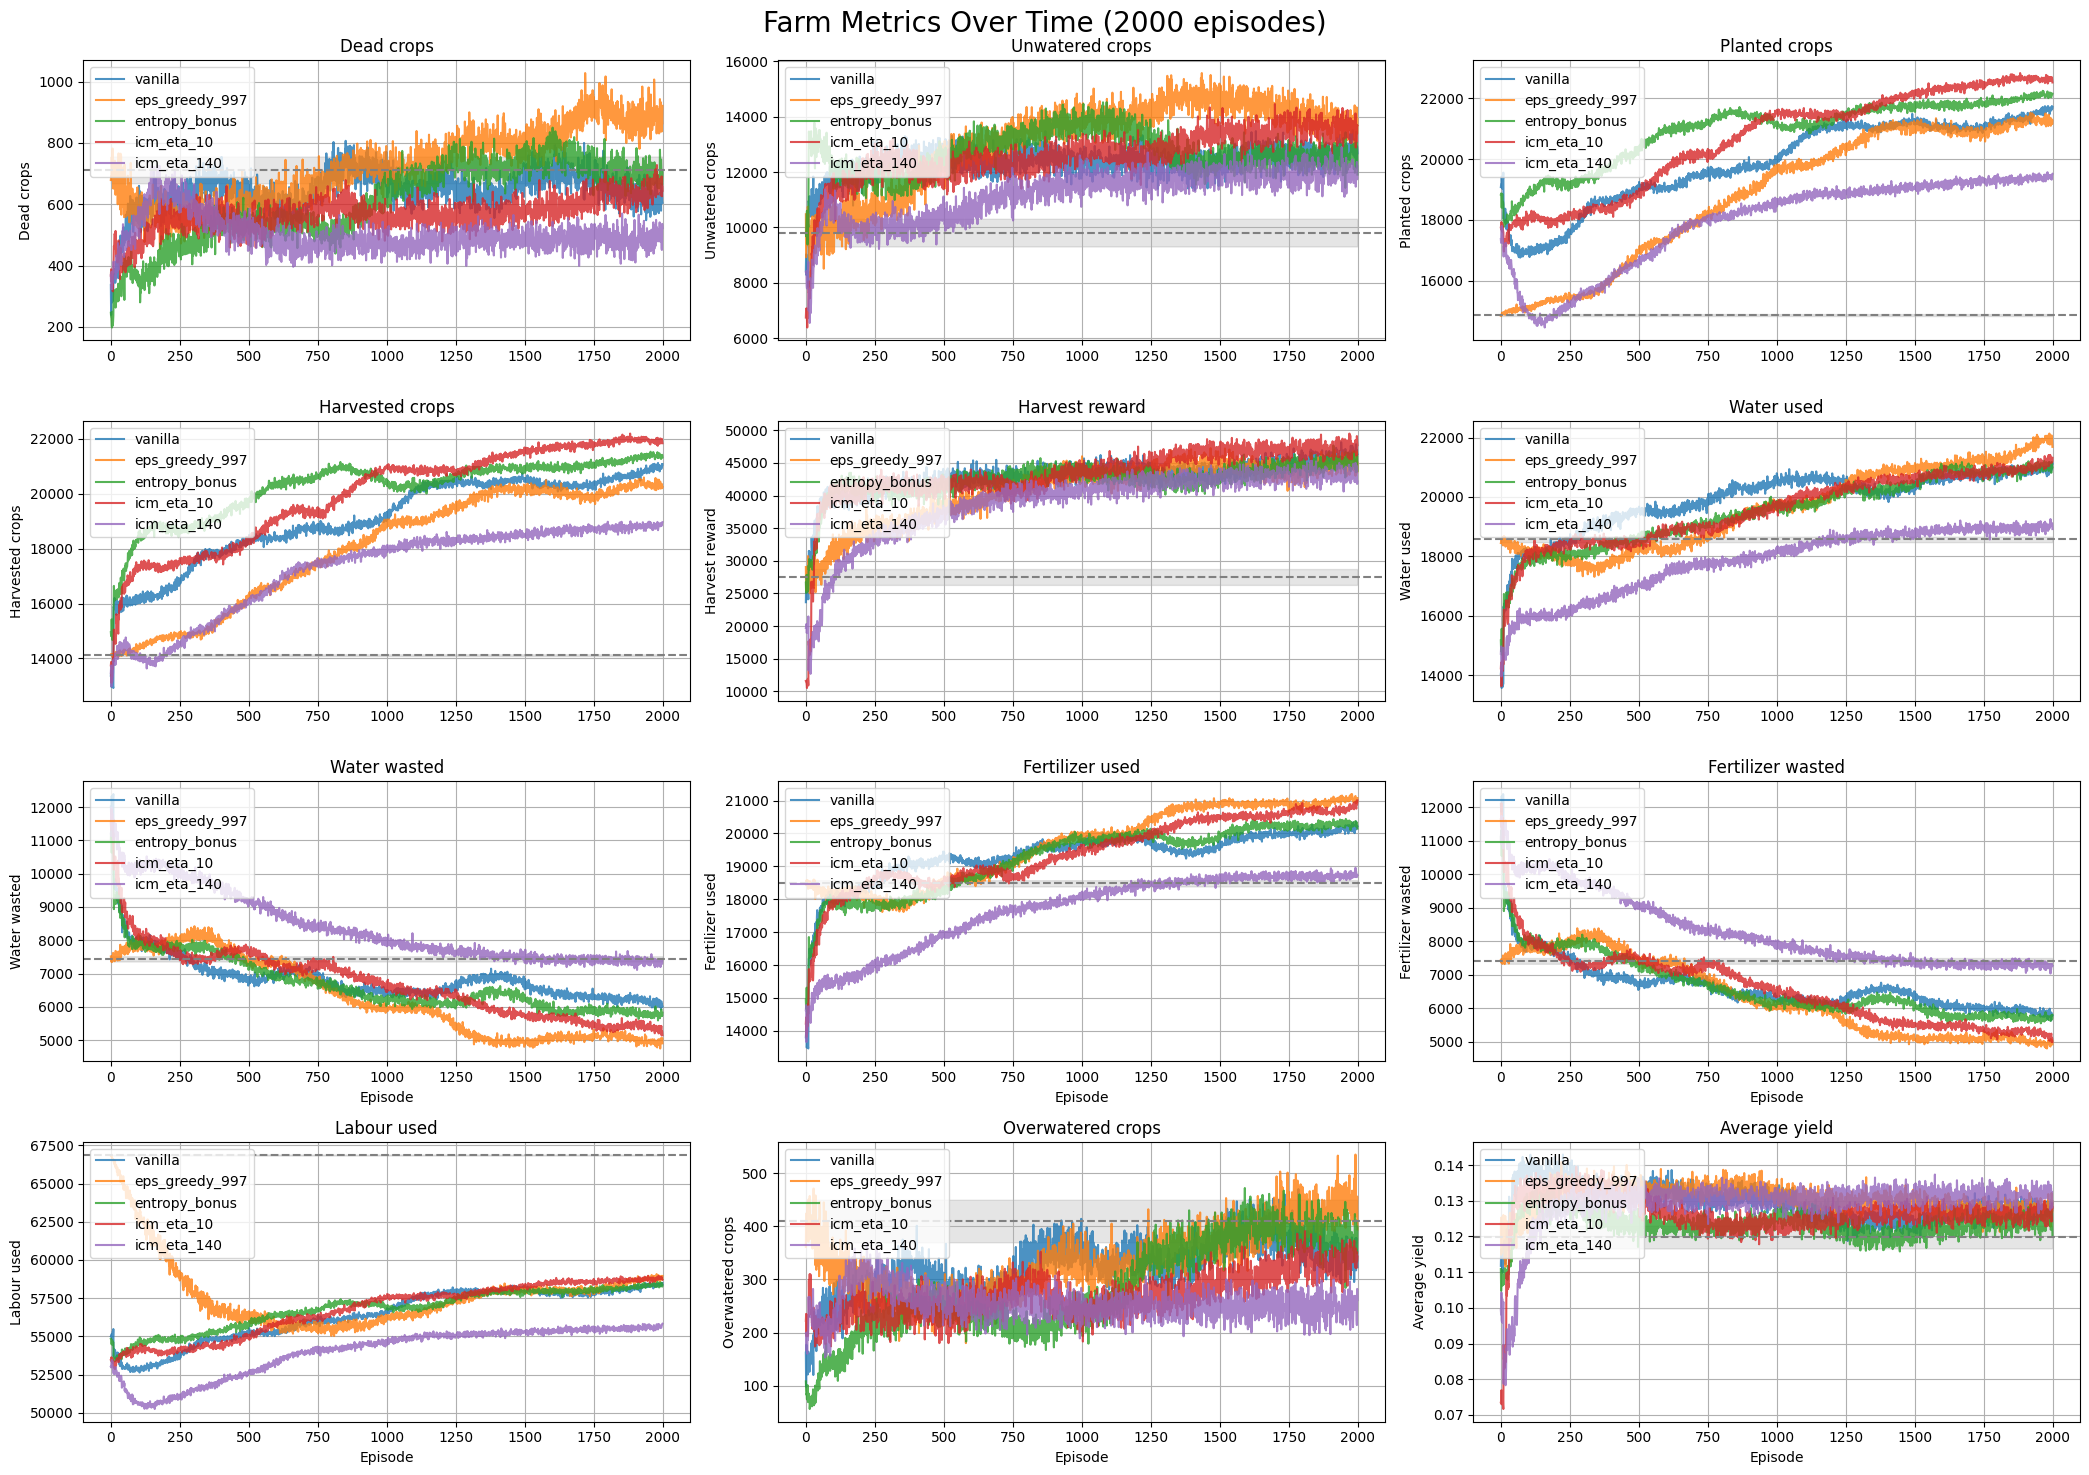

In [8]:
plot_infos(["vanilla", "eps_greedy_997", "entropy_bonus", "icm_eta_10", "icm_eta_140"]) 

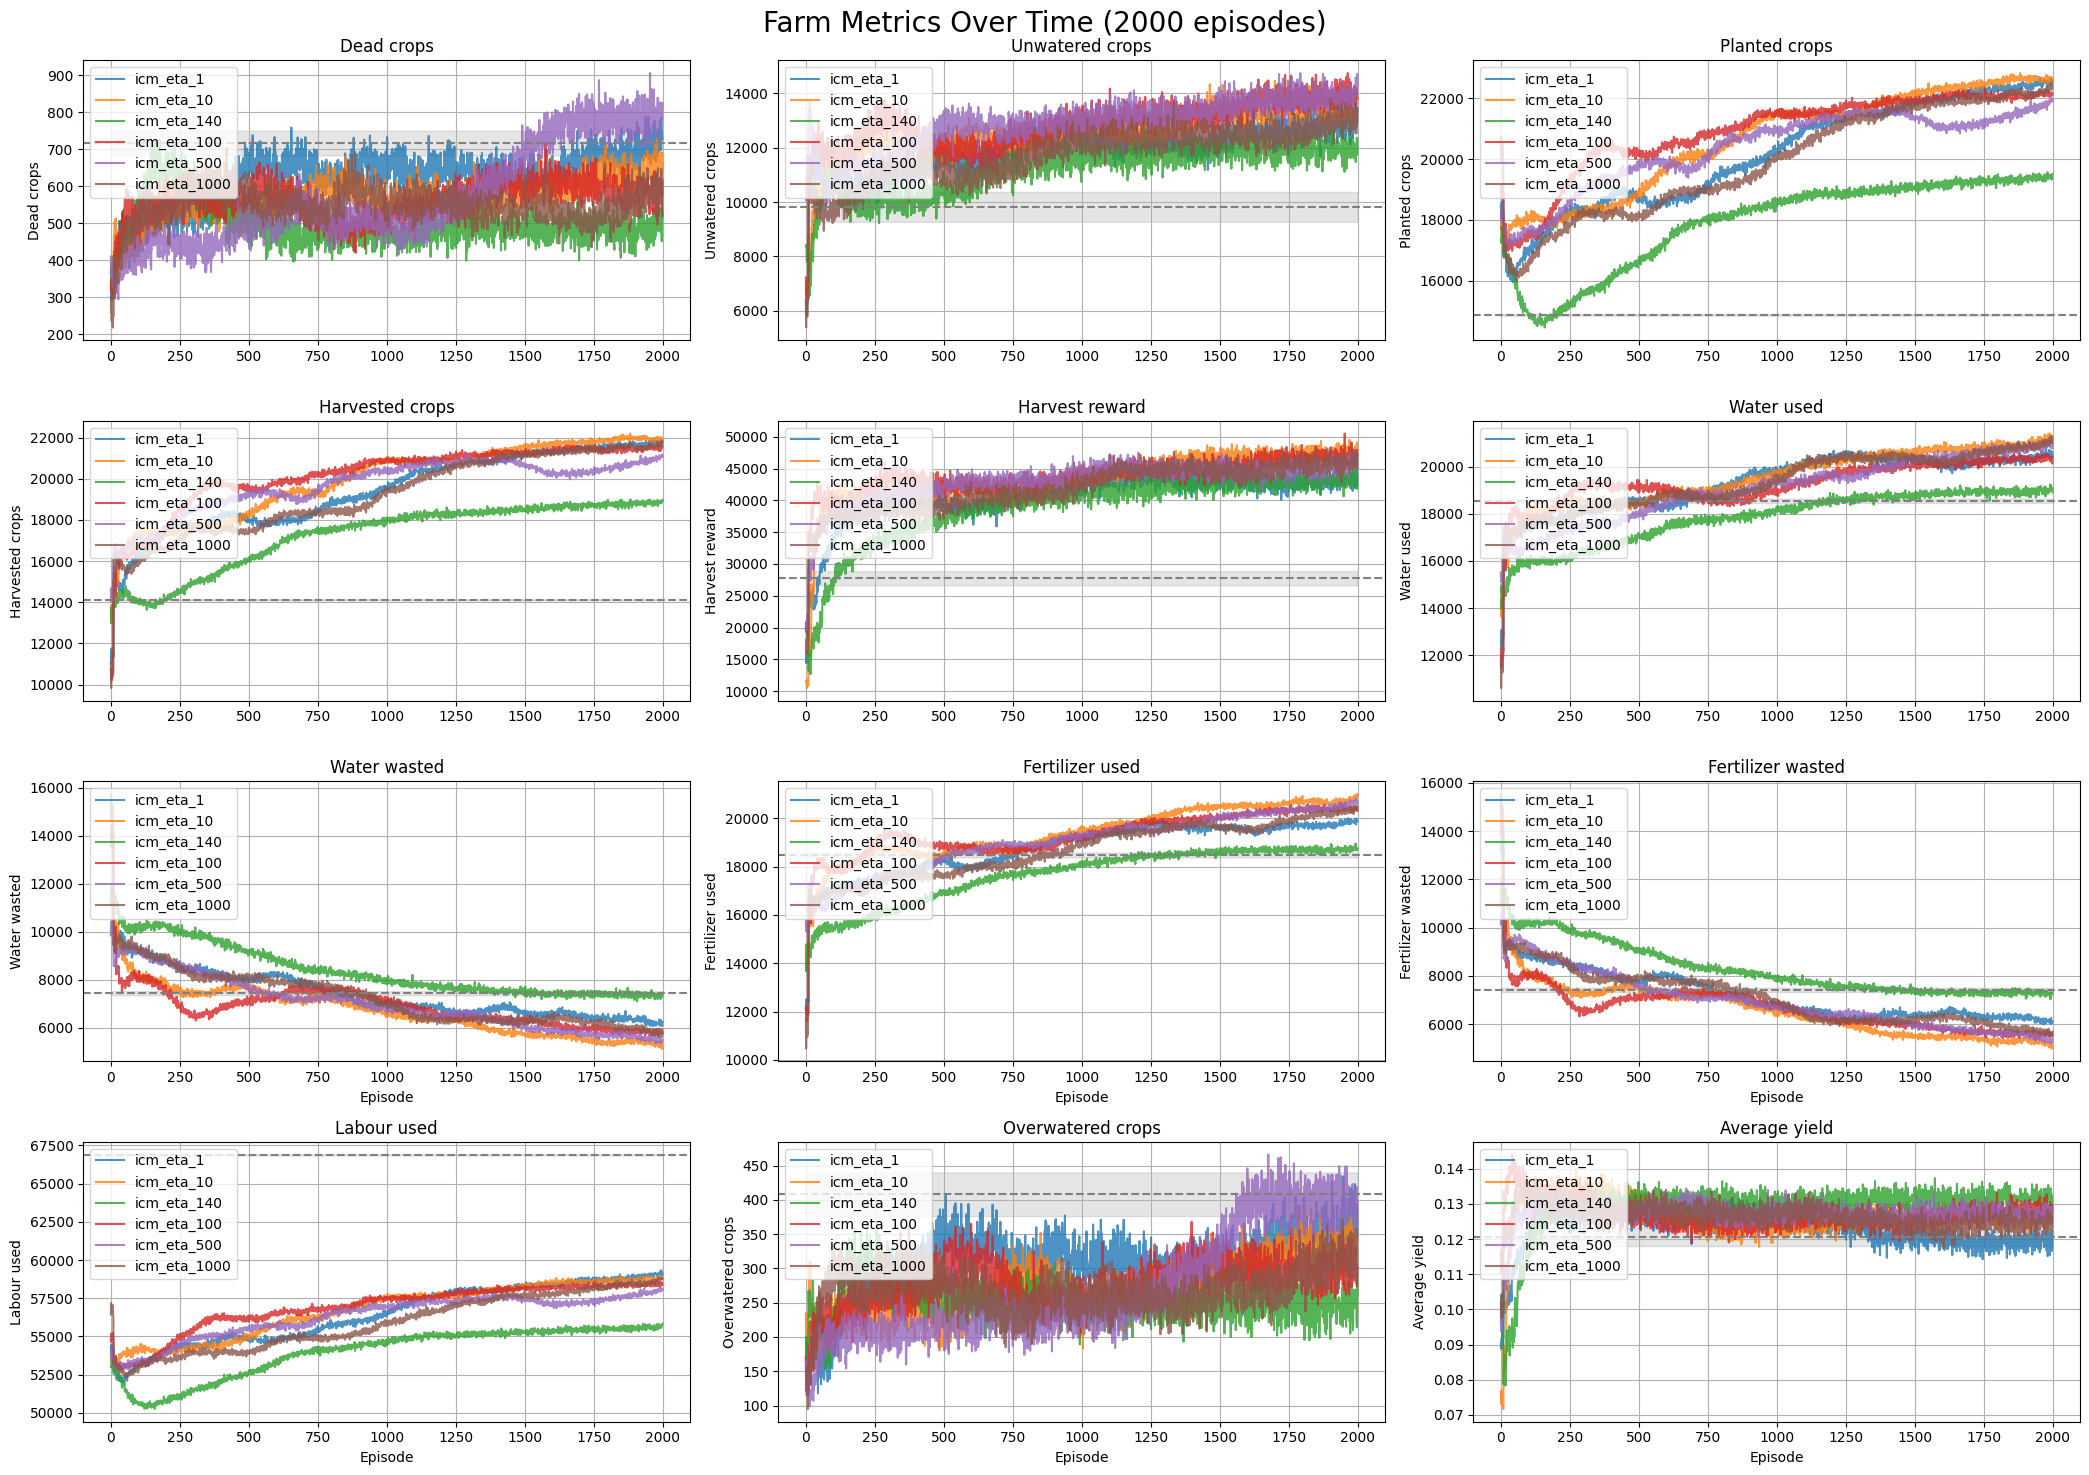

In [16]:
plot_infos(["icm_eta_1", "icm_eta_10", "icm_eta_140", "icm_eta_100", "icm_eta_500", "icm_eta_1000"])

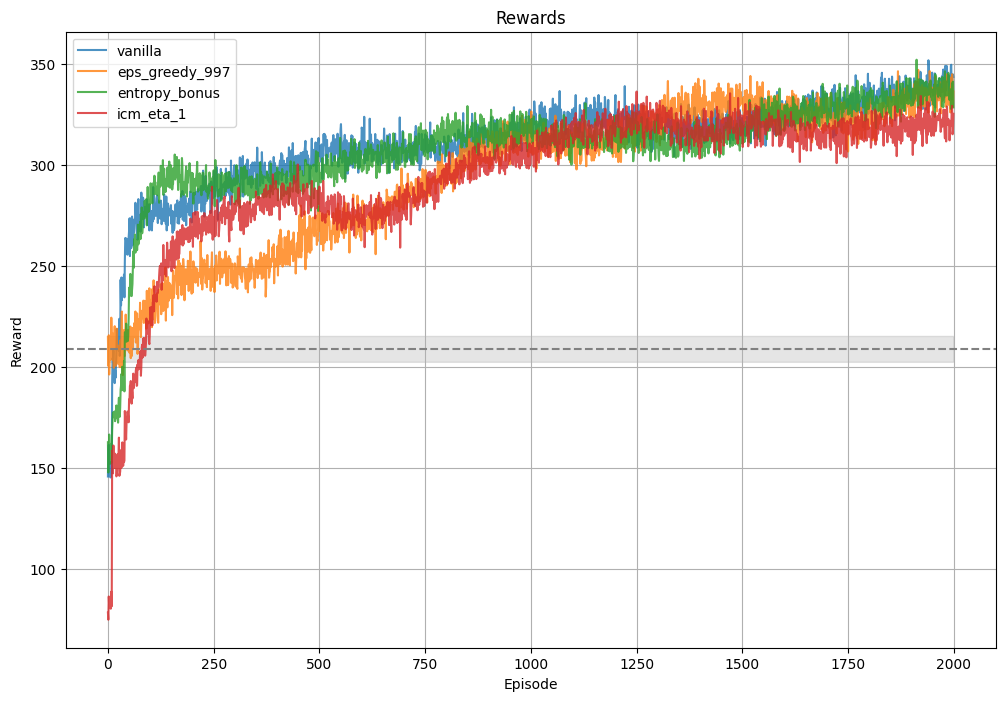

In [15]:
plot_rewards(["vanilla", "eps_greedy_997", "entropy_bonus", "icm_eta_1"])

### Altering environmental settings:
Probably the most interesting knob to play with is the cost of labour, without changing the weekly labour per tile available
In the following results we use different costs of labour, setting them as:
- planting: 1.5
- watering: 0.25
- fertilizing: 0.25
- harvesting: 4.5

The idea is that the agent keeps harvesting early on the growth stages as it is not expensive, hence we try to make watering and fertilizing much cheaper, and harvesting a very labour expensive task

*The baselines are related to the new environment settings*

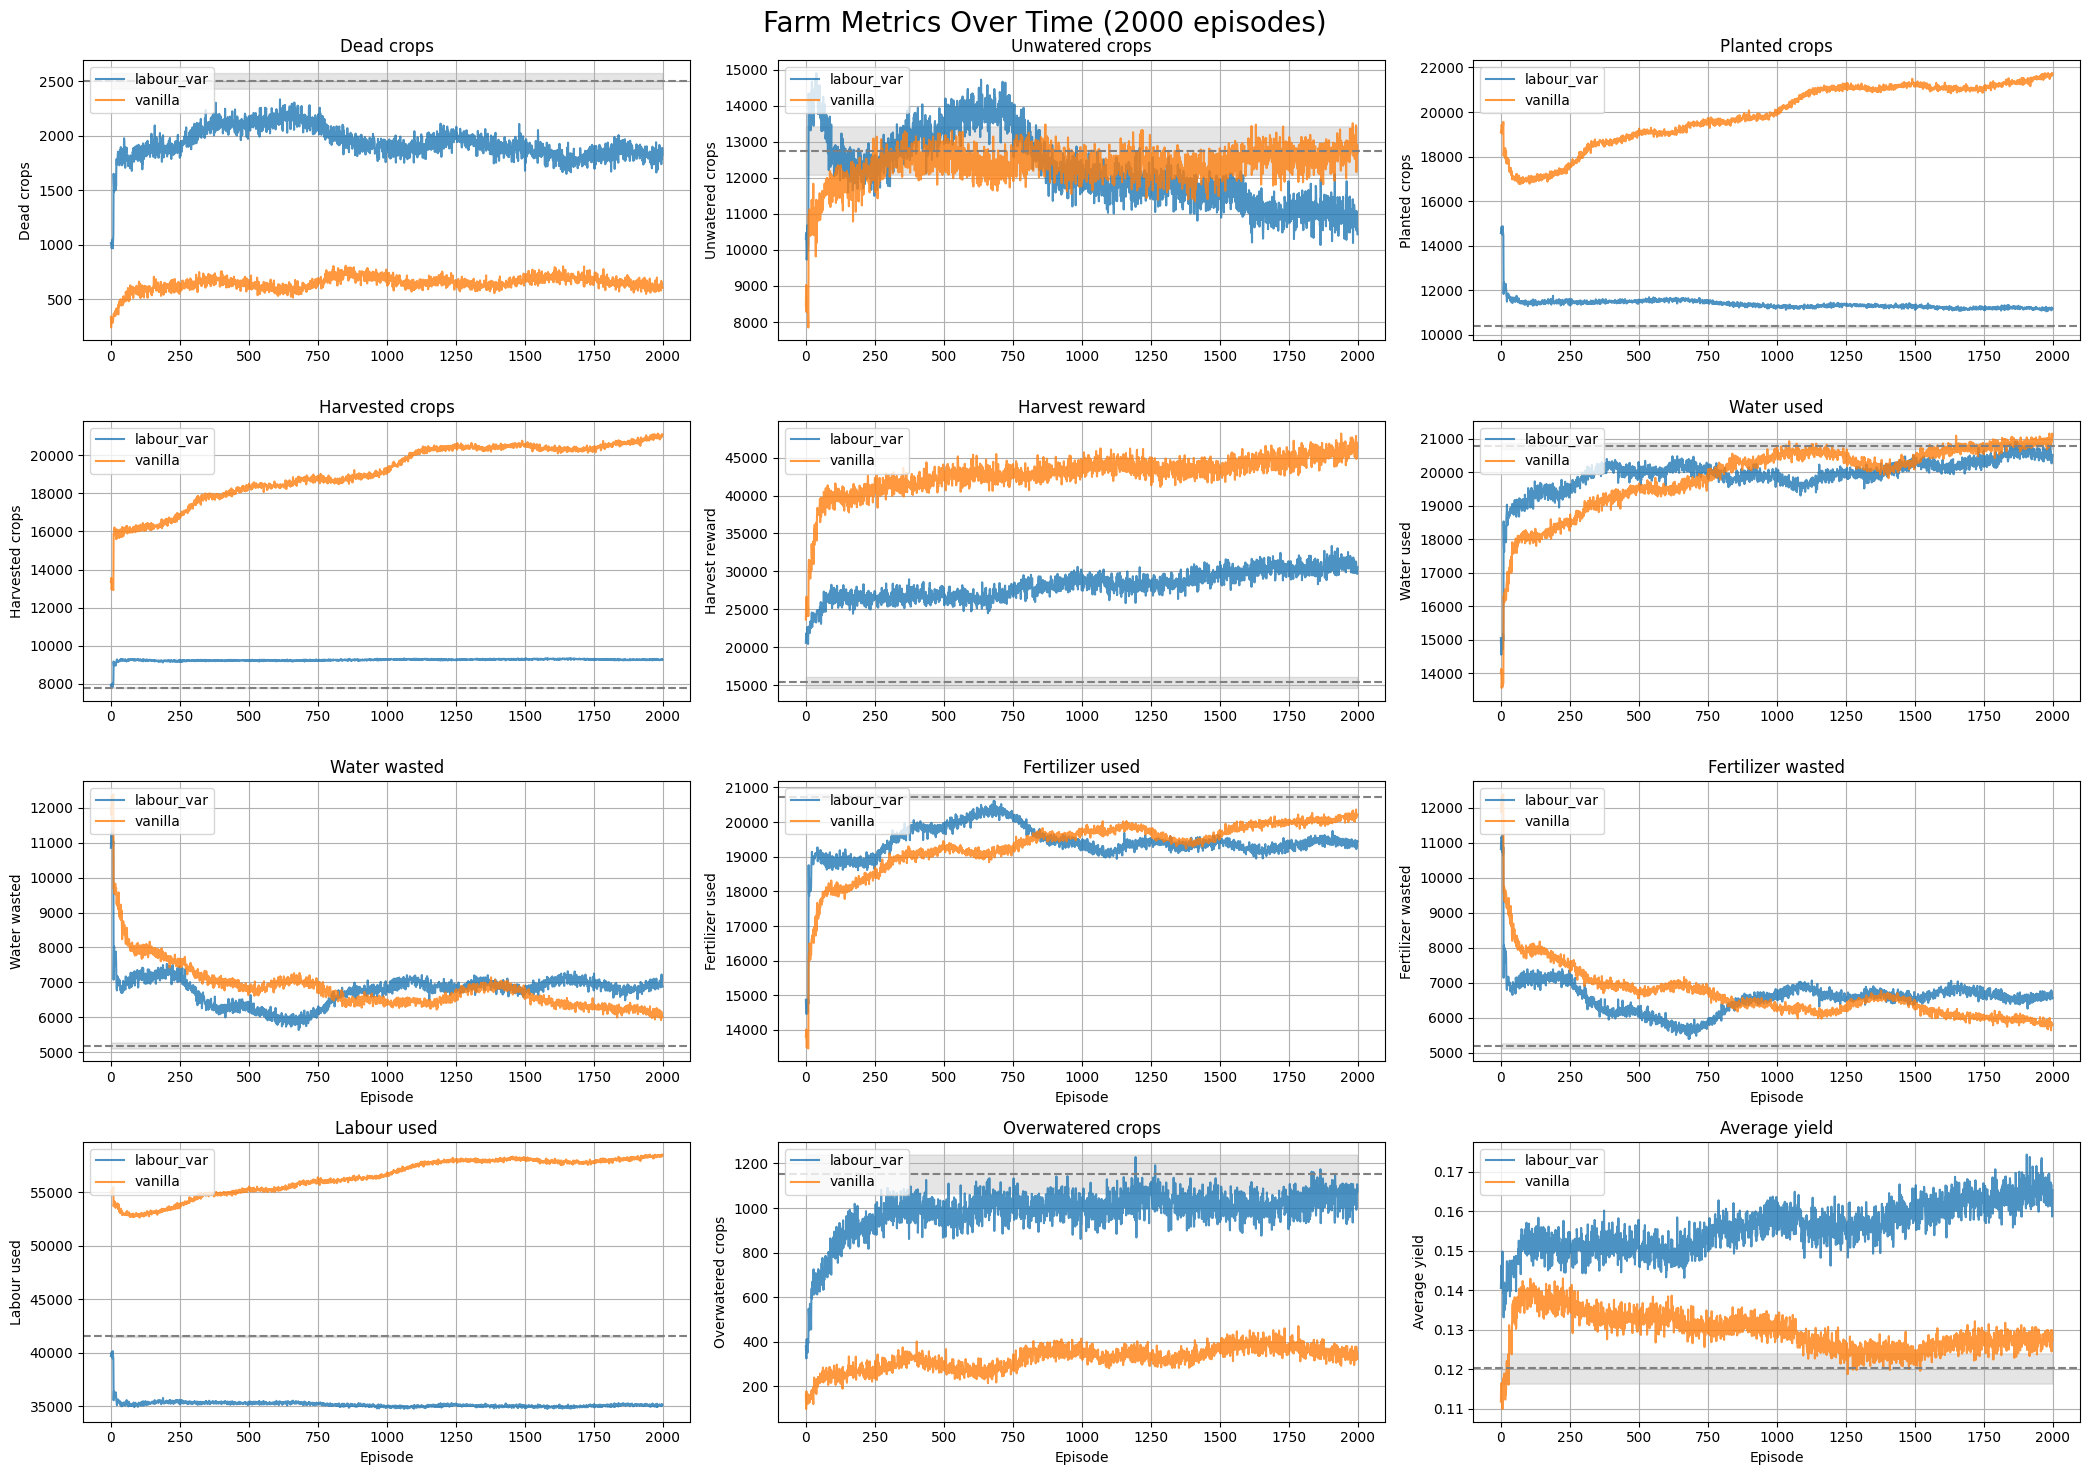

In [ ]:
plot_infos(["labour_var", "vanilla"])